In [1]:
import os
import yaml
import pandas as pd
import sqlalchemy

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from IPython.display import display 
pd.options.display.max_columns = None
%matplotlib inline

import time
from jinja2 import Template

In [2]:
import json
from triage import create_engine

with open('config/san_jose_db.json') as f:
    DB_CONFIG = json.load(f)

conn = create_engine(
    f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['pass']}@{DB_CONFIG['host']}/{DB_CONFIG['db']}"
)

In [3]:
import datetime
from dateutil.relativedelta import relativedelta
base = datetime.datetime.strptime('2016-06-01', '%Y-%m-%d')
date_pairs = []
for x in range(17,-1,-1):
    date_pairs.append(
        (
        (base - relativedelta(months=3*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=3*x) - relativedelta(years=1)).strftime('%Y-%m-%d')
        )
    )
    date_pairs.append(
        (
        (base - relativedelta(months=3*x) - relativedelta(years=1)).strftime('%Y-%m-%d'),
        (base - relativedelta(months=3*x)).strftime('%Y-%m-%d')
        )
    )
print(date_pairs)

[('2011-03-01', '2011-03-01'), ('2011-03-01', '2012-03-01'), ('2011-06-01', '2011-06-01'), ('2011-06-01', '2012-06-01'), ('2011-09-01', '2011-09-01'), ('2011-09-01', '2012-09-01'), ('2011-12-01', '2011-12-01'), ('2011-12-01', '2012-12-01'), ('2012-03-01', '2012-03-01'), ('2012-03-01', '2013-03-01'), ('2012-06-01', '2012-06-01'), ('2012-06-01', '2013-06-01'), ('2012-09-01', '2012-09-01'), ('2012-09-01', '2013-09-01'), ('2012-12-01', '2012-12-01'), ('2012-12-01', '2013-12-01'), ('2013-03-01', '2013-03-01'), ('2013-03-01', '2014-03-01'), ('2013-06-01', '2013-06-01'), ('2013-06-01', '2014-06-01'), ('2013-09-01', '2013-09-01'), ('2013-09-01', '2014-09-01'), ('2013-12-01', '2013-12-01'), ('2013-12-01', '2014-12-01'), ('2014-03-01', '2014-03-01'), ('2014-03-01', '2015-03-01'), ('2014-06-01', '2014-06-01'), ('2014-06-01', '2015-06-01'), ('2014-09-01', '2014-09-01'), ('2014-09-01', '2015-09-01'), ('2014-12-01', '2014-12-01'), ('2014-12-01', '2015-12-01'), ('2015-03-01', '2015-03-01'), ('2015-03

In [4]:
query = Template("""
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_median_income
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)

-- Simple model selection on last time period, baseline with no recall adjustments
SELECT 'Best Unadjusted Metric - Unadjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.base_value AS value,
       r.base_max_recall_ratio AS max_recall_ratio,
       r.base_recall_under55k_to_over55k AS recall_under_to_over,
       r.base_recall_over55k_to_under55k AS recall_over_to_under
FROM {{schema}}.model_adjustment_results_median_income r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
AND r.list_size = 500

UNION ALL

-- Model selection on last time before adjustment, with adjustment applied
SELECT 'Best Unadjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_under55k_to_over55k AS recall_under_to_over,
       r.adj_recall_over55k_to_under55k AS recall_over_to_under
FROM {{schema}}.model_adjustment_results_median_income r
JOIN base_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
AND r.list_size = 500

UNION ALL

-- Model selection on last time after adjustment, with adjustment applied
SELECT 'Best Adjusted Metric - Adjusted'::VARCHAR(128) AS strategy,
       r.train_end_time, r.past_train_end_time,
       r.list_size, r.metric, r.parameter,
       r.adj_value AS value,
       r.adj_max_recall_ratio AS max_recall_ratio,
       r.adj_recall_under55k_to_over55k AS recall_under_to_over,
       r.adj_recall_over55k_to_under55k AS recall_over_to_under
FROM {{schema}}.model_adjustment_results_median_income r
JOIN adj_mgs b
  ON r.model_group_id = b.model_group_id
  AND r.past_train_end_time = b.train_end_time
  AND r.list_size = b.list_size
  AND r.metric = b.metric
  AND r.parameter = b.parameter
WHERE r.train_end_time > r.past_train_end_time
AND r.list_size = 500

UNION ALL

-- Composite model
SELECT 'Composite Model - Adjusted'::VARCHAR(128) AS strategy,
      r.train_end_time AS train_end_time,
      r.past_train_end_time AS past_train_end_time,
      r.list_size, metric, parameter,
      r.value AS value,
      r.max_recall_ratio AS max_recall_ratio,
      r.recall_under55k_to_over55k AS recall_under_to_over,
      r.recall_over55k_to_under55k AS recall_over_to_under
FROM {{schema}}.composite_results_median_income r
WHERE train_end_time > past_train_end_time
AND r.list_size=500
""")

In [5]:
params = {}
params['schema'] = 'hemank_bias_orig'
sql_orig = query.render(**params)
ts_df_orig = pd.read_sql(sql_orig, conn)

params = {}
params['schema'] = 'hemank_bias_nop'
sql_nop = query.render(**params)
ts_df_nop = pd.read_sql(sql_nop, conn)

#params = {}
#params['schema'] = 'hemank_bias_decoupled'
#sql_dec = query.render(**params)
#ts_df_dec = pd.read_sql(sql_dec, conn)

params['schema'] = 'hemank_bias_under_1_orig_orig'
sql_us = query.render(**params)
ts_df_u_v1a = pd.read_sql(sql_us, conn)

params['schema'] = 'hemank_bias_under_original_50_50'
sql_us = query.render(**params)
ts_df_u_v2a = pd.read_sql(sql_us, conn)

params['schema'] = 'hemank_bias_under_original_snop_original'
sql_us = query.render(**params)
ts_df_u_v2b = pd.read_sql(sql_us, conn)

params['schema'] = 'hemank_bias_under_original_50_original'
sql_us = query.render(**params)
ts_df_u_v2c = pd.read_sql(sql_us, conn)

params['schema'] = 'hemank_bias_under_1_50_50'
sql_us = query.render(**params)
ts_df_u_v3a = pd.read_sql(sql_us, conn)

params['schema'] = 'hemank_bias_under_1_snop_original'
sql_us = query.render(**params)
ts_df_u_v3b = pd.read_sql(sql_us, conn)

params['schema'] = 'hemank_bias_over_1_original_original'
sql_os = query.render(**params)
ts_df_o_v1a = pd.read_sql(sql_os, conn)

params['schema'] = 'hemank_bias_over_original_50_50'
sql_os = query.render(**params)
ts_df_o_v2a = pd.read_sql(sql_os, conn)

params['schema'] = 'hemank_bias_over_original_snop_original'
sql_os = query.render(**params)
ts_df_o_v2b = pd.read_sql(sql_os, conn)

params['schema'] = 'hemank_bias_over_original_50_original'
sql_os = query.render(**params)
ts_df_o_v2c = pd.read_sql(sql_os, conn)

params['schema'] = 'hemank_bias_over_1_50_50'
sql_os = query.render(**params)
ts_df_o_v3a = pd.read_sql(sql_os, conn)

params['schema'] = 'hemank_bias_over_1_snop_original'
sql_os = query.render(**params)
ts_df_o_v3b = pd.read_sql(sql_os, conn)

params['schema'] = 'hemank_bias_zafar'
sql_zafar = query.render(**params)
ts_df_zafar = pd.read_sql(sql_zafar, conn)

In [6]:
sql_decoupled = Template("""
WITH mg_rns AS (
  SELECT *,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY base_value DESC, base_max_recall_ratio ASC, RANDOM()) AS rn_base,
         row_number() OVER (PARTITION BY train_end_time, list_size, metric, parameter ORDER BY adj_value DESC, adj_max_recall_ratio ASC, RANDOM()) AS rn_adj
  FROM {{schema}}.model_adjustment_results_median_income
  WHERE past_train_end_time = train_end_time
)
, base_mgs AS (
  SELECT * FROM mg_rns WHERE rn_base = 1
)
, adj_mgs AS (
  SELECT * FROM mg_rns WHERE rn_adj = 1
)


-- -- Composite model (with decoupled models)
SELECT 'Composite w/ Decoupled - Adjusted'::VARCHAR(128) AS strategy,
      train_end_time, past_train_end_time,
      list_size, metric, parameter,
      value,
      max_recall_ratio,
      recall_under55k_to_over55k AS recall_under_to_over,
      recall_over55k_to_under55k AS recall_over_to_under
FROM {{schema}}.composite_results_decoupled_median_income
WHERE train_end_time > past_train_end_time
;
""")

In [7]:
params = {}
params['schema'] = 'hemank_bias_decoupled'
sql_dec = sql_decoupled.render(**params)
ts_df_dec = pd.read_sql(sql_dec, conn)

In [8]:
ts_df_orig['dataset'] = 'Original'
orig_df = ts_df_orig.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
orig_df = orig_df.loc[orig_df['train_end_time'] >= '2014-06-01', ]

ts_df_nop['dataset'] = 'NoP'
nop_df = ts_df_nop.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
nop_df = nop_df.loc[nop_df['train_end_time'] >= '2014-06-01', ]

ts_df_dec['dataset'] = 'DeCoupled'
dec_df = ts_df_dec.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
dec_df = dec_df.loc[dec_df['train_end_time'] >= '2014-06-01']

ts_df_zafar['dataset'] = 'Zafar'
zafar_df = ts_df_zafar.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
zafar_df = zafar_df.loc[zafar_df['train_end_time'] >= '2014-06-01']

ts_df_u_v1a['dataset'] = 'Under-v1a'
u_v1a_df = ts_df_u_v1a.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
u_v1a_df = u_v1a_df.loc[u_v1a_df['train_end_time'] >= '2014-06-01', ]

ts_df_u_v2a['dataset'] = 'Under-v2a'
u_v2a_df = ts_df_u_v2a.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
u_v2a_df = u_v2a_df.loc[u_v2a_df['train_end_time'] >= '2014-06-01', ]

ts_df_u_v2b['dataset'] = 'Under-v2b'
u_v2b_df = ts_df_u_v2b.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
u_v2b_df = u_v2b_df.loc[u_v2b_df['train_end_time'] >= '2014-06-01', ]

ts_df_u_v2c['dataset'] = 'Under-v2c'
u_v2c_df = ts_df_u_v2c.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
u_v2c_df = u_v2c_df.loc[u_v2c_df['train_end_time'] >= '2014-06-01', ]

ts_df_u_v3a['dataset'] = 'Under-v3a'
u_v3a_df = ts_df_u_v3a.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
u_v3a_df = u_v3a_df.loc[u_v3a_df['train_end_time'] >= '2014-06-01', ]


ts_df_u_v3b['dataset'] = 'Under-v3b'
u_v3b_df = ts_df_u_v3b.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
u_v3b_df = u_v3b_df.loc[u_v3b_df['train_end_time'] >= '2014-06-01', ]


ts_df_o_v1a['dataset'] = 'Over-v1a'
o_v1a_df = ts_df_o_v1a.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
o_v1a_df = o_v1a_df.loc[o_v1a_df['train_end_time'] >= '2014-06-01', ]

ts_df_o_v2a['dataset'] = 'Over-v2a'
o_v2a_df = ts_df_o_v2a.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
o_v2a_df = o_v2a_df.loc[o_v2a_df['train_end_time'] >= '2014-06-01', ]

ts_df_o_v2b['dataset'] = 'Over-v2b'
o_v2b_df = ts_df_o_v2b.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
o_v2b_df = o_v2b_df.loc[o_v2b_df['train_end_time'] >= '2014-06-01', ]

ts_df_o_v2c['dataset'] = 'Over-v2c'
o_v2c_df = ts_df_o_v2c.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
o_v2c_df = o_v2c_df.loc[o_v2c_df['train_end_time'] >= '2014-06-01', ]

ts_df_o_v3a['dataset'] = 'Over-v3a'
o_v3a_df = ts_df_o_v3a.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
o_v3a_df = o_v3a_df.loc[o_v3a_df['train_end_time'] >= '2014-06-01', ]

ts_df_o_v3b['dataset'] = 'Over-v3b'
o_v3b_df = ts_df_o_v3b.rename(
    {'recall_over_to_under': 'recall_disp'
    }, axis='columns')
o_v3b_df = o_v3b_df.loc[o_v3b_df['train_end_time'] >= '2014-06-01', ]

In [10]:
all_df = pd.concat([orig_df, nop_df, zafar_df, dec_df])
under_df = pd.concat([orig_df, u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df])
over_df = pd.concat([orig_df, o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

In [10]:
def plot(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(12, 5))
    
    data = comp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 style = 'strategy',
                 markers = True,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset', 'strategy'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []
    for i, lab in enumerate(labels):
        if lab not in list(unique_dfs) + ['dataset', 'strategy']:
            handles[i].set_linestyle("")
        hhandles.append(handles[i])
        llabels.append(lab)
        
    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
#    ax.set_xlim([0.5, 0.58])
    fig.tight_layout()

In [27]:
over_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()

,dataset,strategy,value,recall_disp
0,Original,Best Adjusted Metric - Adjusted,0.787875,1.091208
1,Original,Best Unadjusted Metric - Adjusted,0.790387,1.054190
2,Original,Best Unadjusted Metric - Unadjusted,0.789693,1.775239
3,Original,Composite Model - Adjusted,0.780256,1.079814
4,Over-v1a,Best Adjusted Metric - Adjusted,0.787297,1.060671
5,Over-v1a,Best Unadjusted Metric - Adjusted,0.789226,1.052061
6,Over-v1a,Best Unadjusted Metric - Unadjusted,0.787852,1.715770
7,Over-v1a,Composite Model - Adjusted,0.778524,1.025299
8,Over-v2a,Best Adjusted Metric - Adjusted,0.798269,1.055885
9,Over-v2a,Best Unadjusted Metric - Adjusted,0.797840,1.075247


In [11]:
under_df.groupby(['dataset', 'strategy'])[['value', 'recall_disp']].mean().reset_index()

,dataset,strategy,value,recall_disp
0,Original,Best Adjusted Metric - Adjusted,0.787875,1.091208
1,Original,Best Unadjusted Metric - Adjusted,0.790387,1.054190
2,Original,Best Unadjusted Metric - Unadjusted,0.789693,1.775239
3,Original,Composite Model - Adjusted,0.780256,1.079814
4,Under-v1a,Best Adjusted Metric - Adjusted,0.790171,1.084299
5,Under-v1a,Best Unadjusted Metric - Adjusted,0.793612,1.063161
6,Under-v1a,Best Unadjusted Metric - Unadjusted,0.789381,1.765779
7,Under-v1a,Composite Model - Adjusted,0.793106,1.049249
8,Under-v2a,Best Adjusted Metric - Adjusted,0.787473,1.078245
9,Under-v2a,Best Unadjusted Metric - Adjusted,0.788470,1.023188


In [184]:
#fig_two_df = pd.concat([orig_df, nop_df, zafar_df, decoupled_df])

filtered_original_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_original_df.loc[:,'dataset'] = 'Original'
filtered_original_df.loc[:,'strategy'] = 'No Adjustment'

filtered_adjusted_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Adjusted')]
filtered_adjusted_df.loc[:,'dataset'] = 'Post-hoc Adjustment'
filtered_adjusted_df.loc[:,'strategy'] = 'Post-hoc Adjustment'

filtered_composite_df = orig_df[(orig_df['strategy'] == 'Composite Model - Adjusted')]
filtered_composite_df.loc[:,'dataset'] = 'Composite Adjusted'
filtered_composite_df.loc[:,'strategy'] = 'Composite Adjusted'

filtered_nop_df = nop_df[nop_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_nop_df.loc[:,'dataset'] = 'No Protected'
filtered_nop_df.loc[:,'strategy'] = 'No Protected'

filtered_zafar_df = zafar_df[zafar_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
filtered_zafar_df.loc[:,'dataset'] = 'Regularization'
filtered_zafar_df.loc[:,'strategy'] = 'Regularization'

best_prec_df = u_v3b_df[u_v3b_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
best_prec_df.loc[:,'dataset'] = 'Sampling (Best Precision)'
best_prec_df.loc[:,'strategy'] = 'Sampling (Best Precision)'

best_equity_df = o_v2a_df[o_v2a_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']
best_equity_df.loc[:,'dataset'] = 'Sampling (Best Equity)'
best_equity_df.loc[:,'strategy'] = 'Sampling (Best Equity)'

fig_two_df = pd.concat([filtered_original_df, filtered_nop_df, filtered_zafar_df, 
                        best_prec_df, best_equity_df, filtered_adjusted_df,
                       filtered_composite_df])

fig_three_df = pd.concat([filtered_original_df, filtered_nop_df])
fig_four_df = pd.concat([filtered_original_df, filtered_zafar_df])

decoupled_df = dec_df

filtered_decoupled_df = decoupled_df[(decoupled_df['strategy'] == 'Composite w/ Decoupled - Adjusted')]
filtered_decoupled_df.loc[:,'strategy'] = 'Decoupled'
filtered_decoupled_df.loc[:,'dataset'] = 'Decoupled'

fig_five_df = pd.concat([filtered_original_df, filtered_composite_df, filtered_decoupled_df])

/home/hemank/.pyenv/versions/3.6.9/lib/python3.6/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [265]:
def plot_figure_two(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    #data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected", 
                                                                                        "Sampling (Best Equity)",
                                                                                       "Sampling (Best Precision)",
                                                                                       "Composite Adjusted",
                                                                                       "Regularization", 
                                                                                  "Post-hoc Adjustment"]).reset_index()

    unique_dfs = ["Original", "No Protected", "Sampling (Best Equity)", "Sampling (Best Precision)",
                 "Composite Adjusted", "Regularization", "Post-hoc Adjustment"]
    
    colorlist = ['#001c7f', #Original
                 '#b1400d', #No_Protected
                 '#12711c', #Best Sampling(Equity)
                 '#8c0800', #Best Sampling(Precision)
                 '#591e71', #Composite Adjustment
                 '#592f0d', #Regularization
                 '#a23582', #Post-hoc Adjustment
                 '#3c3c3c', 
                 '#b8850a', 
                 '#006374', 
                 '#001c7f', 
                 '#b1400d']

    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 color = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    #unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('')
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0, 1.0], [1.0, 1.0], linestyle='--', color='black')
    ax.tick_params(axis='x', labelsize=22)
    ax.tick_params(axis='y', labelsize=24)
    #ax.get_legend().remove()
    ax.plot([0.0,1.0], [1.0, 1.0], color='black', linestyle='--')
    ax.set_xlim([0.75,0.82])
    ax.legend().remove()
    fig.tight_layout()

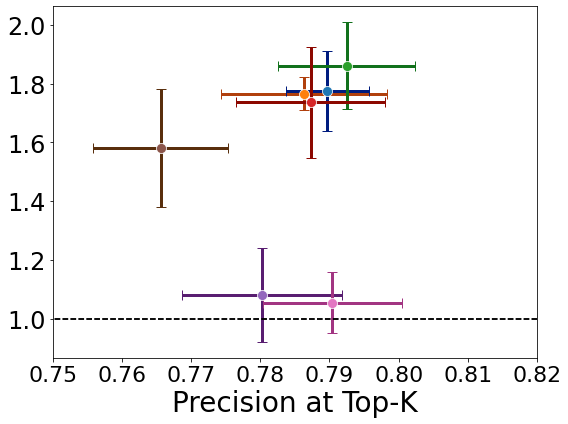

In [266]:
plot_figure_two(fig_two_df)
plt.savefig('../../PLOTS2/PLOTS_Summary/SanJose_Methods.pdf')

In [281]:
def plot_figure_three(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', #Original
                 '#b1400d']
    unique_dfs = ["Original", "No Protected"]
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "No Protected"]
        
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=24, 
              bbox_to_anchor=(0.025, 0.125), 
              loc='lower left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.set_ylim([0.9, 2.0])
    ax.set_xlim([0.75, 0.81])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

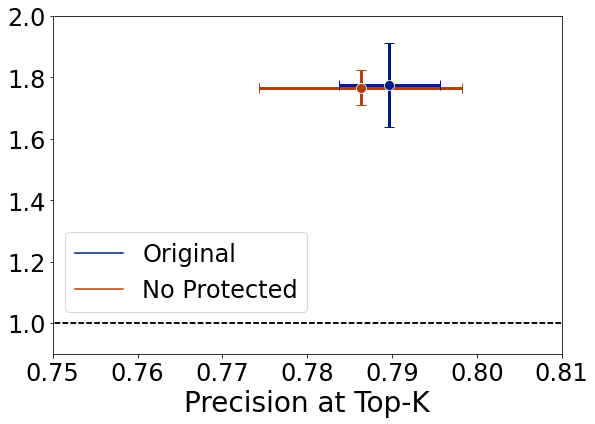

In [282]:
plot_figure_three(fig_three_df)
plt.savefig('../../PLOTS2/PLOTS_NOP/NoP_SanJose.pdf')

In [285]:
def plot_figure_four(comp_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Regularization"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', '#592f0d'] #Regularization
    
    unique_dfs = ["Original", "Regularization"]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
    
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=24, 
              bbox_to_anchor=(0.0125, 0.125), 
              loc='lower left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.set_ylim([0.88, 2.1])
    ax.set_xlim([0.74, 0.82])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

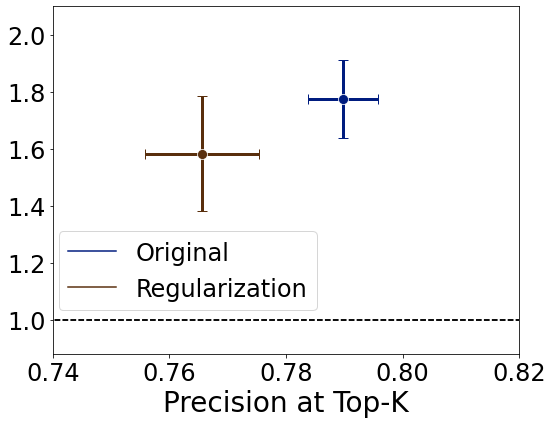

In [286]:
plot_figure_four(fig_four_df)
plt.savefig('../../PLOTS2/PLOTS_Zafar/sanjose_zafar.pdf')

In [291]:
def plot_figure_five(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Composite Adjusted", "Decoupled"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                 '#591e71', # Composite Adjustment
                 '#3c3c3c' # Decoupled
                ]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Composite Adjusted", "Decoupled"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles[1:], llabels[1:], fontsize=20, 
              bbox_to_anchor=(0.015, 0.975), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)    
    ax.set_ylim([0.6, 2.1])
    ax.set_xlim([0.7, 0.82])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    #ax.legend().remove()
    fig.tight_layout()

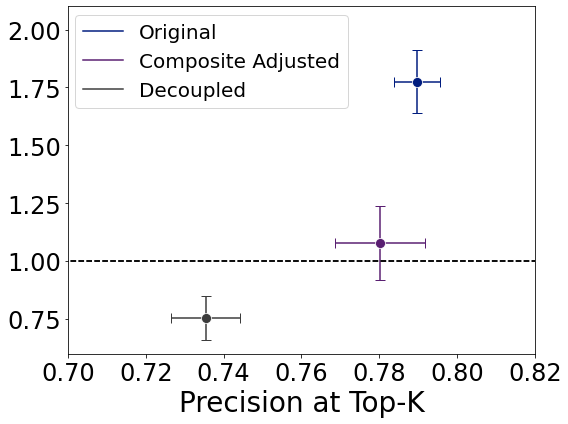

In [292]:
plot_figure_five(fig_five_df)
plt.savefig('../../PLOTS2/PLOTS_Composite/Composite_SanJose.pdf')

In [195]:
def get_mode(x):
    if "Original" in x:
        return "Original"
    elif "U" in x:
        return "Under"
    return "Over"

usamp_df = pd.concat([u_v1a_df, u_v2a_df, u_v2b_df, u_v2c_df, u_v3a_df, u_v3b_df])
osamp_df = pd.concat([o_v1a_df, o_v2a_df, o_v2b_df, o_v2c_df, o_v3a_df, o_v3b_df])

filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_usamp_df = usamp_df[(usamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_osamp_df = osamp_df[(osamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]

fig_six_df = pd.concat([filtered_orig_df, filtered_usamp_df, filtered_osamp_df])
fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='Original', 'mode'] = 'Original'
fig_six_df.loc[fig_six_df['dataset']=='Under-v1a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2c', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3b', 'dataset'] = '6'

fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='Over-v1a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2c', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3b', 'dataset'] = '6'

fig_six_df = fig_six_df.rename(columns={"dataset": "Method", "mode":"Mode"})

In [196]:
fig_six_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()

,Method,Mode,value,recall_disp
0,Original,Original,0.789693,1.775239
1,1,Under,0.789381,1.765779
2,2,Under,0.787398,1.773112
3,3,Under,0.785522,1.730591
4,4,Under,0.787885,1.994012
5,5,Under,0.779569,1.837413
6,6,Under,0.787298,1.736505
7,1,Over,0.787852,1.715770
8,2,Over,0.792495,1.861694
9,3,Over,0.789482,1.744420


In [325]:
def plot_figure_six(comp_df):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    colorlist = ['#001c7f', #Original
                 '#12711c', 
                 #'#23fab9', 
                 #'#00875e',
                 #'#3fb9c4',
                 '#a2ff00']
                 #'#688c29']
    
    data = comp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), ("5", "Over"), ("6", "Over")]).reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'Mode',
                 style = 'Method',
                 markers = True,
                 palette = colorlist,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = [("Original","Original"),
                  ("1","Under"), ("1","Over"),
                  ("2","Under"),("2","Over"),
                  ("3","Under"),("3","Over"),
                  ("4","Under"),("4","Over"),
                  ("5","Under"),("5","Over"),
                  ("6","Under"),("6","Over")]
    
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[(comp_df['Method'] == unique_dfs[i][0]) & (comp_df['Mode']==unique_dfs[i][1]), ].copy()
        
        x_coords = list(tmp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['Method', 'Mode'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        
        prec_errors = 1.96*tmp_df.groupby(['Method', 'Mode'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['Method', 'Mode'])['recall_disp'].sem().values
    
        mode = unique_dfs[i][1]
        if mode == "Original":
            color = colorlist[0]
        elif mode == "Under":
            color = colorlist[1]
        else:
            color = colorlist[2]
            
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = color, fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    #for i, lab in enumerate(labels):
    #    if lab not in list(unique_dfs):
    #        handles[i].set_linestyle("")
    #        lab = "Methods"
    #    hhandles.append(handles[i])
    #    llabels.append(lab)

    ax.legend(handles, labels, fontsize=18, 
              bbox_to_anchor=(0.015, 0.985), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)
    
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    ax.set_xlim([0.735, 0.82])
    fig.tight_layout()

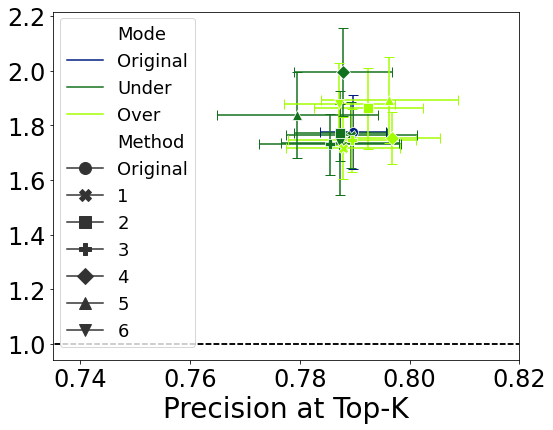

In [326]:
plot_figure_six(fig_six_df)
plt.savefig('../../PLOTS2/PLOTS_Sampling/SanJose_Sampling.pdf')

In [208]:
fig_seven_df = pd.concat([filtered_orig_df, filtered_adjusted_df])

In [327]:
def plot_figure_seven(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(8, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Post-hoc Adjustment"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                '#a23582']

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Post-hoc Adjustment"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('', fontsize=32)
    ax.set_xlabel('Precision at Top-K', fontsize=28)
    ax.plot([0.0,1.0],[1.0, 1.0], linestyle = '--', color='black')
    
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=24)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)
    
    llabels = ['Methods', 'Original', 'Post-hoc\nAdjustment']
    ax.legend(hhandles[1:], llabels[1:], fontsize=20, 
              bbox_to_anchor=(0.01, 0.985), 
              loc='upper left', 
              borderaxespad=0., markerscale=2, ncol=1)    
    ax.set_ylim([0.9, 2.0])
    ax.set_xlim([0.75, 0.82])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    #ax.legend().remove()
    fig.tight_layout()

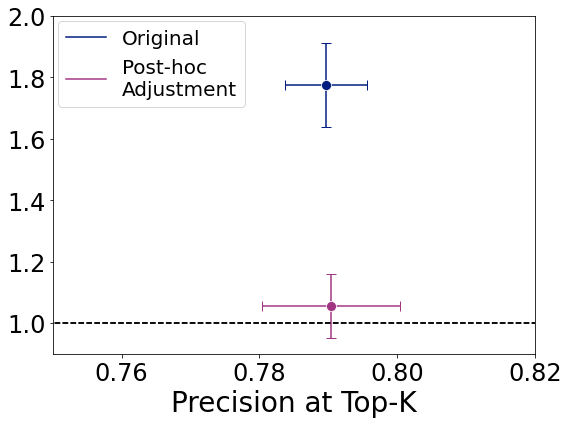

In [328]:
plot_figure_seven(fig_seven_df)
plt.savefig('../../PLOTS2/PLOTS_Post/sanjose_post.pdf')

In [30]:
fig_one_df = pd.concat([filtered_orig_df, filtered_nop_df, filtered_zafar_df, best_usamp_prec_df, 
                       best_usamp_equity_df, best_osamp_prec_df, best_osamp_equity_df, dec_df])

fig_one_df.loc[fig_one_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_one_df.loc[fig_one_df['strategy']=='Best Unadjusted Metric - Adjusted', 'strategy'] = 'Adjusted'
fig_one_df.loc[fig_one_df['strategy']=='Composite w/ Decoupled - Adjusted','strategy'] = 'Decoupled Adjusted'
fig_one_df.loc[fig_one_df['strategy']=='Composite Model - Adjusted','strategy'] = 'Composite Adjusted'

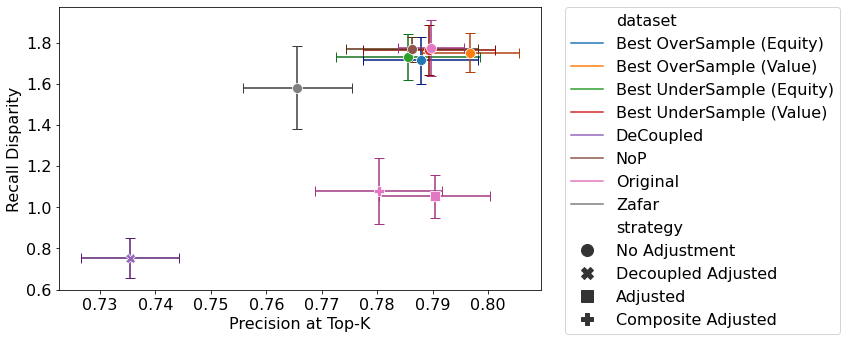

In [34]:
plot(fig_one_df)
plt.savefig('../../PLOTS2/San_Jose_Summary.pdf')

In [103]:
fig_three_df = pd.concat([orig_df, nop_df])
filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_nop_df = nop_df[nop_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']

fig_three_df = pd.concat([filtered_orig_df, filtered_nop_df])
fig_three_df.loc[fig_three_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_three_df.loc[(fig_three_df['dataset']=='NoP'),'dataset'] = 'No Protected'

In [118]:
def plot_figure_three(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(10, 6))
    
    #data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "No Protected"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', #Original
                 '#b1400d', #No_Protected
                 '#12711c', #Best Sampling(Equity)
                 '#8c0800', #Best Sampling(Precision)
                 '#591e71', #Composite Adjustment
                 '#592f0d', #Regularization
                 '#a23582', #Post-hoc Adjustment
                 '#3c3c3c', 
                 '#b8850a', 
                 '#006374', 
                 '#001c7f', 
                 '#b1400d']

    unique_dfs = ["Original", "No Protected"]
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 color = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "No Protected"]
    #unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
            sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 color = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    #unique_dfs = np.unique(data['dataset'])
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
        
    ax.set_ylabel('Recall Disparity', fontsize=20)
    ax.set_xlabel('Precision at Top-K', fontsize=20)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.get_legend().remove()
    
    '''
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    '''
    #ax.set_ylim([0.9, 2.2])
    ax.set_xlim([0.77, 0.82])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

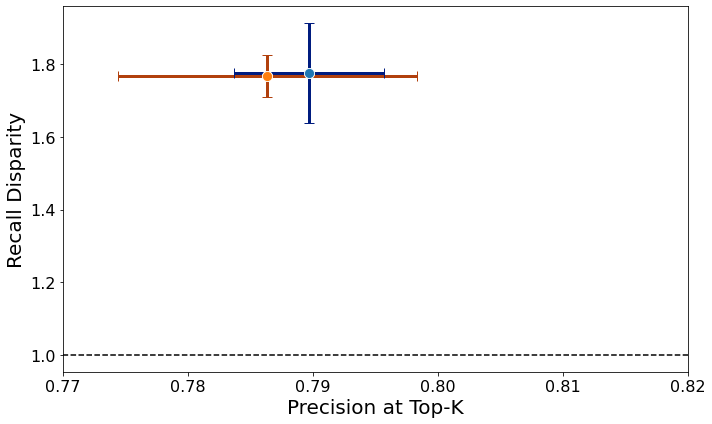

In [120]:
plot_figure_three(fig_three_df)
plt.savefig('../../PLOTS2/PLOTS_NOP/NoP_SanJose.pdf')

In [102]:
pd.value_counts(fig_three_df['dataset'])

No Protected    14
Original        14
Name: dataset, dtype: int64

In [121]:
fig_four_df = pd.concat([orig_df, zafar_df])
filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_zafar_df = zafar_df[zafar_df['strategy'] == 'Best Unadjusted Metric - Unadjusted']

fig_four_df = pd.concat([filtered_orig_df, filtered_zafar_df])
fig_four_df.loc[fig_four_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'Original'
fig_four_df.loc[(fig_four_df['dataset']=='Zafar'),'dataset'] = 'Regularization'

pd.value_counts(fig_four_df['dataset'].values)

Regularization    14
Original          14
dtype: int64

In [132]:
def plot_figure_four(comp_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Regularization"]
                                                                                ).reset_index()
    colorlist = ['#001c7f', '#592f0d'] #Regularization
    
    unique_dfs = ["Original", "Regularization"]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 linewidth = 20.0,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
    
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5, linewidth=3.0)
        
    ax.set_ylabel('Recall Disparity', fontsize=20)
    ax.set_xlabel('Precision at Top-K', fontsize=20)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.get_legend().remove()
    
    '''
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    '''
    ax.set_ylim([0.9, 2.0])
    ax.set_xlim([0.74, 0.81])
    ax.plot([0.0, 1.0], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

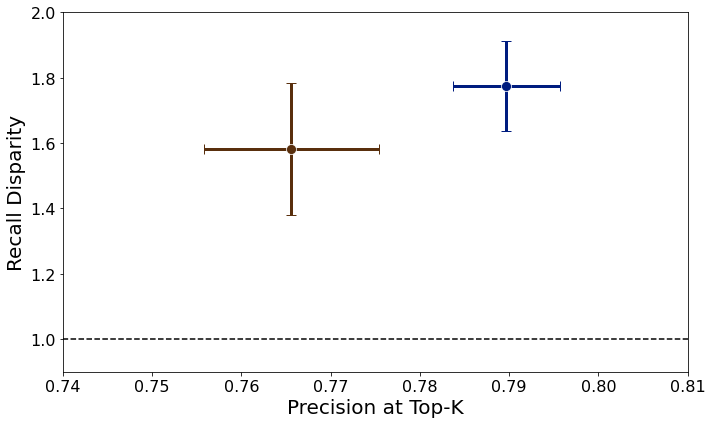

In [133]:
plot_figure_four(fig_four_df)
plt.savefig('../../PLOTS2/PLOTS_Zafar/sanjose_zafar.pdf')

In [138]:
decoupled_df = dec_df
filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted') |
                           (orig_df['strategy'] == 'Composite Model - Adjusted')]
filtered_decoupled_df = decoupled_df[(decoupled_df['strategy'] == 'Composite w/ Decoupled - Adjusted')]

fig_five_df = pd.concat([filtered_orig_df, filtered_decoupled_df])
fig_five_df.loc[fig_five_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_five_df.loc[fig_five_df['strategy']=='Composite Model - Adjusted', 'dataset'] = 'Composite'
fig_five_df.loc[fig_five_df['strategy']=='Composite Model - Adjusted', 'strategy'] = 'Adjustment'
fig_five_df.loc[fig_five_df['dataset']=='DeCoupled','dataset'] = 'Decoupled'
pd.value_counts(fig_five_df['dataset'])

Decoupled    27
Original     14
Composite     9
Name: dataset, dtype: int64

In [145]:
def plot_figure_five(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(10, 6))
    
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Composite", "Decoupled"]
                                                                                ).reset_index()

    colorlist = ['#001c7f', #Original
                 '#591e71', # Composite Adjustment
                 '#3c3c3c' # Decoupled
                ]

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 palette = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Composite", "Decoupled"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    ax.set_ylim([0.6, 2.0])
    ax.set_xlim([0.7, 0.82])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

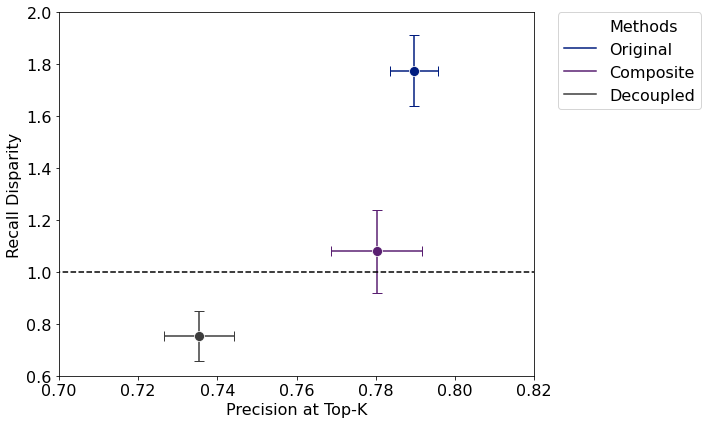

In [146]:
plot_figure_five(fig_five_df)
plt.savefig('../../PLOTS2/PLOTS_Composite/Composite_SanJose.pdf')

In [72]:
def get_mode(x):
    if "Original" in x:
        return "Original"
    elif "U" in x:
        return "Under"
    return "Over"

usamp_df = under_df
osamp_df = over_df

filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_usamp_df = usamp_df[(usamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
filtered_osamp_df = osamp_df[(osamp_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')]
fig_six_df = pd.concat([filtered_orig_df, filtered_usamp_df, filtered_osamp_df])

fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'

fig_six_df.loc[fig_six_df['dataset']=='Original', 'mode'] = 'Original'
fig_six_df.loc[fig_six_df['dataset']=='Under-v1a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2c', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3a', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3b', 'mode'] = 'Under'
fig_six_df.loc[fig_six_df['dataset']=='Under-v3b', 'dataset'] = '6'

fig_six_df.loc[fig_six_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_six_df.loc[fig_six_df['dataset']=='Over-v1a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v1a', 'dataset'] = '1'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2a', 'dataset'] = '2'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2b', 'dataset'] = '3'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2c', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v2c', 'dataset'] = '4'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3a', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3a', 'dataset'] = '5'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3b', 'mode'] = 'Over'
fig_six_df.loc[fig_six_df['dataset']=='Over-v3b', 'dataset'] = '6'

In [73]:
pd.value_counts(fig_six_df['dataset'])

Original    42
1           28
2           28
6           28
4           28
3           28
5           28
Name: dataset, dtype: int64

In [80]:
def plot_figure_six(comp_df):
    colorlist = sns.color_palette("dark", 14).as_hex()
    fig, ax = plt.subplots(figsize=(10, 7))
    
    data = comp_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reindex([
        ("Original", "Original"),
        ("1", "Under"), ("2", "Under"), ("3", "Under"),
        ("4", "Under"), 
        ("5", "Under"), ("6", "Under"), 
        ("1", "Over"), ("2", "Over"), ("3", "Over"), 
        ("4", "Over"), 
        ("5", "Over"), ("6", "Over")]).reset_index()
    
    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 style = 'mode',
                 markers = True,
                 color = colorlist,
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "1", "2", "3", 
                  "4", 
                  "5", "6"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset', 'mode'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset', 'mode'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset', 'mode'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []
    for i, lab in enumerate(labels):
        if lab not in list(unique_dfs) + ['dataset', 'mode']:
            handles[i].set_linestyle("")
        hhandles.append(handles[i])
        llabels.append(lab)
        
    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    ax.set_xlim([0.74, 0.82])
    fig.tight_layout()

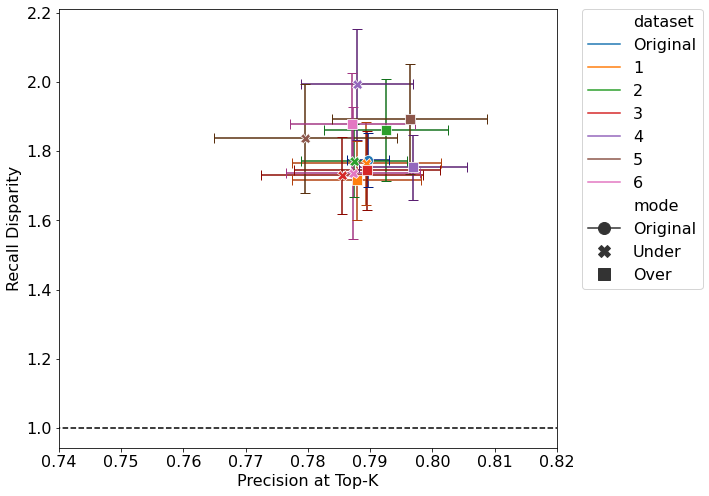

In [82]:
plot_figure_six(fig_six_df)
plt.savefig('../../PLOTS2/PLOTS_Sampling/SanJose_Sampling.pdf')

In [89]:
def plot_figure_seven(comp_df):
    colorlist = sns.color_palette("dark", 12).as_hex()
    fig, ax = plt.subplots(figsize=(12, 5))
    
    #data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()
    data = comp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reindex(["Original", "Adjusted"]).reset_index()

    sns.lineplot(data = data,
                 x='value', y='recall_disp',
                 hue = 'dataset',
                 markers = True,
                 color = colorlist,
                 marker = "o",
                 markersize = 10,
                 dashes = None,
                 ci = None,
                 ax = ax)
    
    unique_dfs = ["Original", "Adjusted"]
    
    for i in range(len(unique_dfs)):
        tmp_df = comp_df.loc[comp_df['dataset'] == unique_dfs[i], ].copy()
        
        x_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['value'].values)
        y_coords = list(tmp_df.groupby(['dataset'])[['value', 'recall_disp']].mean().reset_index()['recall_disp'].values)
        
        prec_errors = 1.96*tmp_df.groupby(['dataset'])['value'].sem().values
        disp_errors = 1.96*tmp_df.groupby(['dataset'])['recall_disp'].sem().values
        
        color = colorlist[i]
        
        ax.errorbar(x_coords, y_coords,
                   xerr = prec_errors,
                   yerr = disp_errors,
                   ecolor = colorlist[i], fmt= ' ', zorder=-1, capsize=5)
        
    ax.set_ylabel('Recall Disparity', fontsize=16)
    ax.set_xlabel('Precision at Top-K', fontsize=16)
    
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    handles, labels = ax.get_legend_handles_labels()
    hhandles = []
    llabels = []

    for i, lab in enumerate(labels):
        #if lab not in list(unique_dfs):# + ['dataset']:
        #    handles[i].set_linestyle("")
        if lab not in list(unique_dfs):
            handles[i].set_linestyle("")
            lab = "Methods"
        hhandles.append(handles[i])
        llabels.append(lab)

    ax.legend(hhandles, llabels, fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., markerscale=2)
    ax.set_xlim([0.77, 0.83])
    ax.plot([0.1, 0.9], [1.0, 1.0], color='black', linestyle='--')
    fig.tight_layout()

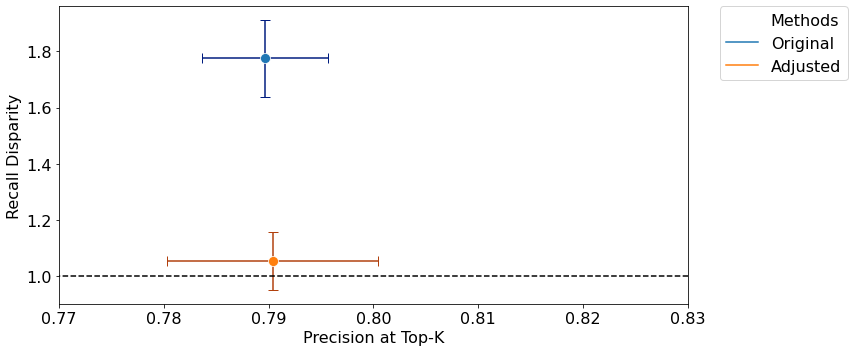

In [91]:
filtered_orig_df = orig_df[(orig_df['strategy'] == 'Best Unadjusted Metric - Unadjusted')|
                          (orig_df['strategy'] == 'Best Unadjusted Metric - Adjusted')]
fig_seven_df = pd.concat([filtered_orig_df])

fig_seven_df.loc[fig_seven_df['strategy']=='Best Unadjusted Metric - Unadjusted', 'strategy'] = 'No Adjustment'
fig_seven_df.loc[fig_seven_df['strategy']=='Best Unadjusted Metric - Adjusted', 'strategy'] = 'Adjusted'

fig_seven_df.loc[fig_seven_df['strategy']=='No Adjustment', 'dataset'] = 'Original'
fig_seven_df.loc[fig_seven_df['strategy']=='Adjusted', 'dataset'] = 'Adjusted'

plot_figure_seven(fig_seven_df)
plt.savefig('../../PLOTS2/PLOTS_Post/san_jose_post.pdf')